# PROCESS MINING FINAL PROJECT 2020-2021
## Train models without timestamp information
### AUTHOR: Ma Jiawei
### LECTURERS: De Leoni Massimiliano, Di Francescomarino Chiara 

### Load datasets

In [1]:
import numpy as np

In [2]:
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')

In [3]:
print(X_train.shape)
print(Y_train.shape)

(912, 20)
(912,)


In [4]:
X_test = np.load('X_test.npy')
Y_test = np.load('Y_test.npy')
print(X_test.shape)
print(Y_test.shape)

(228, 20)
(228,)


Verify if the training and test dataset is balanced

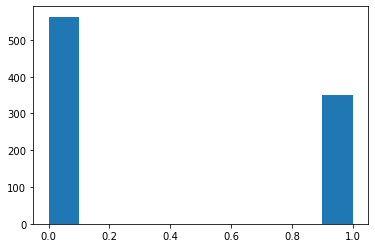

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.hist(Y_train)

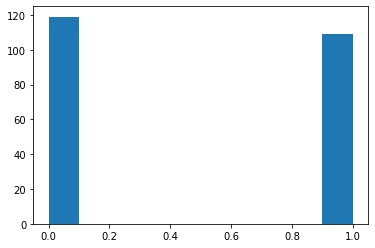

In [6]:
_ = plt.hist(Y_test)

Unfortunately the training dataset is not so balanced.

Standardize the data because the models will have better performance:

In [7]:
import copy 

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Training models

### Logistic regression with different regularization method

In [10]:
from sklearn.linear_model import LogisticRegression

No regularization:

In [11]:
logistic_model = LogisticRegression(penalty='none',random_state=0).fit(X_train, Y_train)
print('Training accuracy logistic_model: ', logistic_model.score(X_train, Y_train))
print('Test accuracy logistic_model: ', logistic_model.score(X_test, Y_test))

Training accuracy logistic_model:  0.7774122807017544
Test accuracy logistic_model:  0.6096491228070176


L2 regularization:

In [12]:
logistic_model_l2 = LogisticRegression(penalty='l2',random_state=0).fit(X_train, Y_train)
print('Training accuracy logistic_model_l2: ', logistic_model_l2.score(X_train, Y_train))
print('Test accuracy logistic_model_l2: ', logistic_model_l2.score(X_test, Y_test))

Training accuracy logistic_model_l2:  0.7785087719298246
Test accuracy logistic_model_l2:  0.6096491228070176


L1 regularization:

In [13]:
logistic_model_l1 = LogisticRegression(penalty='l1',random_state=0, solver='saga').fit(X_train, Y_train)
print('Training accuracy logistic_model_l1: ', logistic_model_l1.score(X_train, Y_train))
print('Test accuracy logistic_model_l1: ', logistic_model_l1.score(X_test, Y_test))

Training accuracy logistic_model_l1:  0.7763157894736842
Test accuracy logistic_model_l1:  0.6096491228070176


Elasticnet regularization:

In [14]:
logistic_model_elastic = LogisticRegression(penalty='elasticnet',random_state=0, solver='saga',
                                           l1_ratio=0.5).fit(X_train, Y_train)
print('Training accuracy logistic_model_elastic: ', logistic_model_elastic.score(X_train, Y_train))
print('Test accuracy logistic_model_elastic: ', logistic_model_elastic.score(X_test, Y_test))

Training accuracy logistic_model_elastic:  0.7763157894736842
Test accuracy logistic_model_elastic:  0.6096491228070176


The models are quite similar.

### Support Vector Machines using CV

In [15]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [16]:
parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
grid_model = GridSearchCV(svm.SVC(), parameters, n_jobs=4)
grid_model.fit(X=X_train, y=Y_train)
svm_model = grid_model.best_estimator_
print (grid_model.best_score_, grid_model.best_params_)
print('Test accuracy svm_model: ', svm_model.score(X_test, Y_test))

0.7390079865489702 {'kernel': 'sigmoid'}
Test accuracy svm_model:  0.5394736842105263


Higher test accuracy w.r.t. the logistic regression models.

### Decision Tree with CV

In [9]:
from sklearn import tree

In [13]:
parameters = {'max_depth':range(1,50)}
grid_model = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
grid_model.fit(X=X_train, y=Y_train)
tree_model = grid_model.best_estimator_
print (grid_model.best_score_, grid_model.best_params_)

0.7752717228127064 {'max_depth': 3}


In [14]:
tree_model.score(X_test, Y_test)

0.5964912280701754

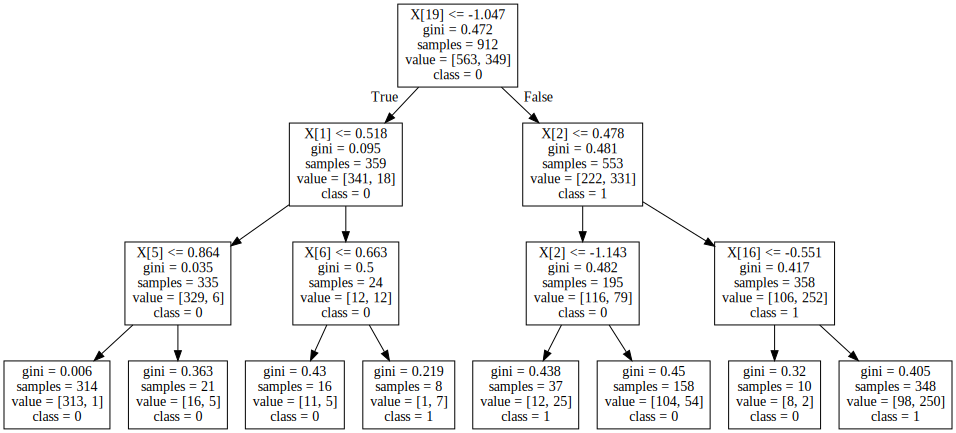

In [15]:
import graphviz
dot_data = tree.export_graphviz(tree_model, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph

Extract a samples with last event represented by a number < -1.047 and then go back to non-scaled dataset:

In [16]:
indices = []
for i,sample in enumerate(X_train):
    if sample[19]<=-1.047:
        indices.append(i)

In [17]:
X_train_unscaled = scaler.inverse_transform(X_train)

In [18]:
np.unique(X_train_unscaled[indices][:,19])

array([0.])

It's difficult to interprete the tree diagram in this case, but we can easily observe that if a sequence has ***length shorter than PL (=20)*** then we can be almost sure that the case will be classified as 0.

Save it as .png:

In [19]:
import pydot
(graph,) = pydot.graph_from_dot_data(dot_data)
graph.write_png('decision_tree.png')

### Random Forest with CV

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
parameters = {'max_depth':range(1,20), 'n_estimators':range(1,30)}
grid_model = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=4)
grid_model.fit(X=X_train, y=Y_train)
forest_model = grid_model.best_estimator_
print (grid_model.best_score_, grid_model.best_params_)

0.7686723112952621 {'max_depth': 3, 'n_estimators': 24}


In [37]:
forest_model.score(X_test, Y_test)

0.5921052631578947

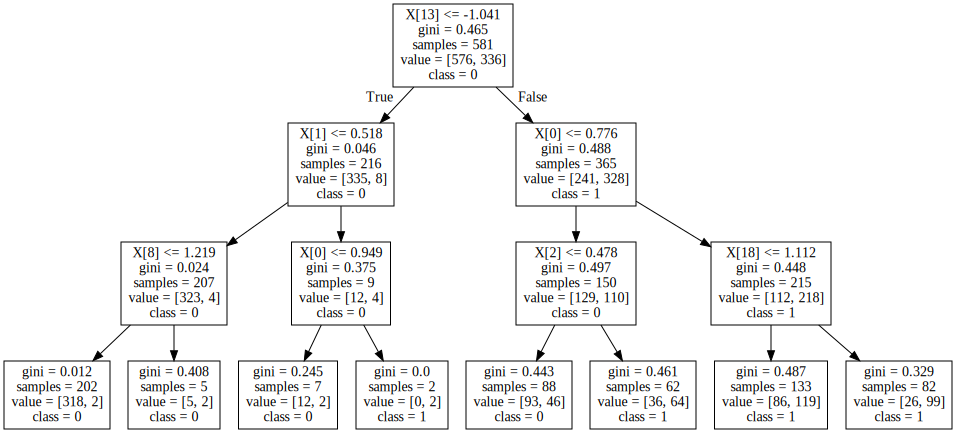

In [52]:
estimator = forest_model.estimators_[6]
dot_data = tree.export_graphviz(estimator, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph

Save it as .png:

In [53]:
(graph,) = pydot.graph_from_dot_data(dot_data)
graph.write_png('random_forest_6.png')

We are going to do same thing as in the decision tree model case:

In [54]:
indices = []
for i,sample in enumerate(X_train):
    if sample[13]<=-1.041:
        indices.append(i)

In [55]:
np.unique(X_train_unscaled[indices][:,13]).astype(np.int)

array([ 0,  4, 17, 21])

(array([322.,   0.,   0.,   1.,   0.,   1.,   0.,  10.,   1.,   1.]),
 array([2.84217094e-14, 5.40000000e+01, 1.08000000e+02, 1.62000000e+02,
        2.16000000e+02, 2.70000000e+02, 3.24000000e+02, 3.78000000e+02,
        4.32000000e+02, 4.86000000e+02, 5.40000000e+02]),
 <BarContainer object of 10 artists>)

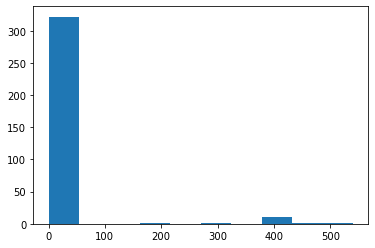

In [56]:
plt.hist(X_train_unscaled[indices][:,16])

***Same conclusion as before***.

Plot importances:

Feature ranking:
1. feature 13 (0.198540)
2. feature 18 (0.166434)
3. feature 15 (0.105961)
4. feature 12 (0.076987)
5. feature 2 (0.074171)
6. feature 16 (0.067090)
7. feature 14 (0.064034)
8. feature 10 (0.062724)
9. feature 19 (0.042338)
10. feature 1 (0.036464)
11. feature 9 (0.029675)
12. feature 0 (0.016533)
13. feature 6 (0.015698)
14. feature 7 (0.009186)
15. feature 3 (0.008500)
16. feature 5 (0.008092)
17. feature 4 (0.007841)
18. feature 8 (0.007072)
19. feature 11 (0.002662)
20. feature 17 (0.000000)


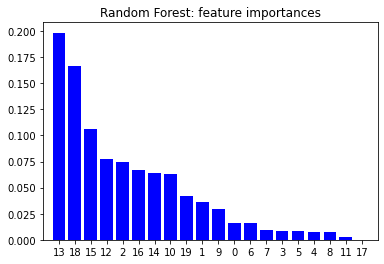

In [57]:
importances = forest_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Random Forest: feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="blue", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.savefig('random_forest_importance.png')
plt.show()

### Gradient Boost Model with CV

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

In [59]:
parameters = {'max_depth':range(1,20), 'learning_rate':[1,0.1,0.01]}
grid_model = GridSearchCV(GradientBoostingClassifier(), parameters, n_jobs=4)
grid_model.fit(X=X_train, y=Y_train)
GB_model = grid_model.best_estimator_
print (grid_model.best_score_, grid_model.best_params_)

0.7741548069416921 {'learning_rate': 0.1, 'max_depth': 3}


In [60]:
GB_model.score(X_test, Y_test)

0.6140350877192983

In [61]:
print('N trees: ', GB_model.n_estimators_)

N trees:  100


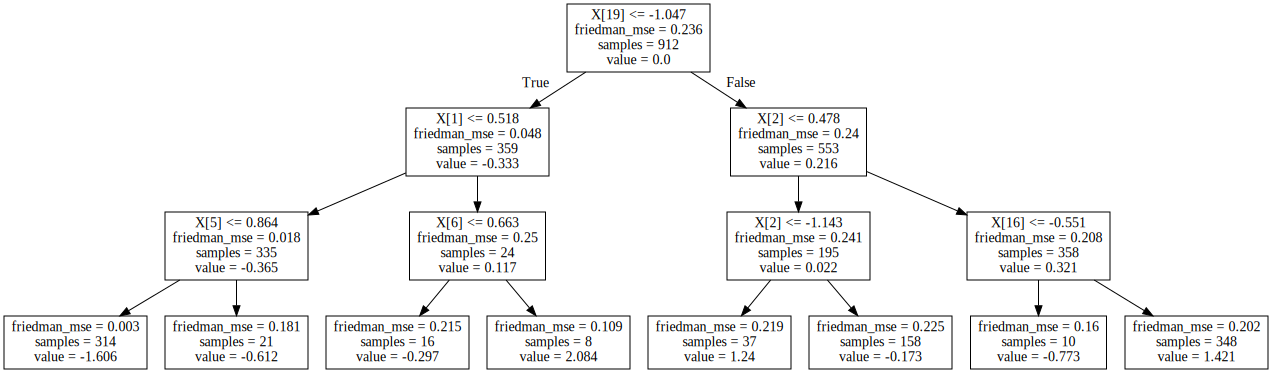

In [62]:
estimator = GB_model.estimators_[0,0]
dot_data = tree.export_graphviz(estimator, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph

Save it as .png:

In [63]:
(graph,) = pydot.graph_from_dot_data(dot_data)
graph.write_png('GB_0.png')

***Very similar to the decision model result .***

Plot importances:

Feature ranking:
1. feature 19 (0.199462)
2. feature 18 (0.198037)
3. feature 2 (0.112950)
4. feature 16 (0.092130)
5. feature 1 (0.080347)
6. feature 15 (0.069197)
7. feature 12 (0.030034)
8. feature 0 (0.026571)
9. feature 4 (0.026195)
10. feature 6 (0.023896)
11. feature 3 (0.020071)
12. feature 13 (0.017084)
13. feature 10 (0.016586)
14. feature 8 (0.015590)
15. feature 14 (0.015477)
16. feature 7 (0.015235)
17. feature 17 (0.014693)
18. feature 5 (0.014580)
19. feature 9 (0.007793)
20. feature 11 (0.004072)


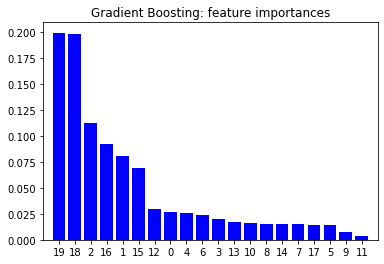

In [64]:
importances = GB_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Gradient Boosting: feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="blue", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.savefig('GB_importance.png')
plt.show()

### DL models: MLP and RNNs with GRID search

In [146]:
import tensorflow as tf

### MLP

In [193]:
def build_fc_model(n_units=30, learning_rate=1e-3, regularizer='l2'):
    model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(n_units, activation="relu", kernel_regularizer=regularizer),
                                    tf.keras.layers.Dense(n_units, activation="relu", kernel_regularizer=regularizer),
                                    tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=regularizer)
                                     ]) 
    model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=["accuracy"])
    return model

keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fc_model)

In [194]:
param_distribs = {
    "n_units": [50, 80, 100],
    "learning_rate": [1e-3, 1e-4],
    "regularizer": ['l1','l2']}

In [195]:
grid_search = GridSearchCV(keras_reg, param_distribs)

In [196]:
grid_search.fit(X_train, Y_train, epochs=100, shuffle=True, batch_size=128, verbose=0)

6/6 [==============================] - 0s 1ms/step - loss: 0.6411 - accuracy: 0.7967


GridSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fb406eee790>,
             param_grid={'learning_rate': [0.001, 0.0001],
                         'n_units': [50, 80, 100],
                         'regularizer': ['l1', 'l2']})

In [197]:
fc_model_pred = fc_model.predict(X_train)
print('Training accuracy: ', np.mean((fc_model_pred>=0.5).squeeze().astype(int) == Y_train))
fc_model_pred = fc_model.predict(X_test)
print('Test accuracy: ', np.mean((fc_model_pred>=0.5).squeeze().astype(int) == Y_test))

Hyperparameters:  {'learning_rate': 0.001, 'n_units': 50, 'regularizer': 'l2'}
Training accuracy:  0.7905701754385965
Test accuracy:  0.6008771929824561


In [157]:
fc_model.summary()

Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_363 (Dense)            (None, 50)                1050      
_________________________________________________________________
dense_364 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_365 (Dense)            (None, 1)                 51        
Total params: 3,651
Trainable params: 3,651
Non-trainable params: 0
_________________________________________________________________


In [210]:
fc_model = build_fc_model(50, 1e-3, 'l2')
fc_model.fit(X_train, Y_train, epochs=100, shuffle=True, batch_size=128, verbose=0)

fc_model_pred = fc_model.predict(X_train)
print('Training accuracy: ', np.mean((fc_model_pred>=0.5).squeeze().astype(int) == Y_train))
fc_model_pred = fc_model.predict(X_test)
print('Test accuracy: ', np.mean((fc_model_pred>=0.5).squeeze().astype(int) == Y_test))

Training accuracy:  0.7927631578947368
Test accuracy:  0.6052631578947368


### RNN with LSTM

In [212]:
def build_lstm_model(n_lstm=4 ,n_units=50, learning_rate=1e-3):
    lstm_model = tf.keras.models.Sequential()
    lstm_model.add(tf.keras.layers.LSTM(n_lstm, return_sequences=True))
    lstm_model.add(tf.keras.layers.LSTM(n_lstm))
    lstm_model.add(tf.keras.layers.Dense(n_units, activation='relu', kernel_regularizer='l2'))
    lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer='l2'))
    
    lstm_model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=["accuracy"])
    return lstm_model

In [213]:
param_distribs = {
    "n_lstm": [4, 10],
    "n_units": [30, 60],
    "learning_rate": [1e-2, 1e-3]}
keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_lstm_model)
grid_search = GridSearchCV(keras_reg, param_distribs)

In [214]:
grid_search = GridSearchCV(keras_reg, param_distribs)
grid_search.fit(np.expand_dims(X_train, axis=-1), Y_train, epochs=80, batch_size=128, shuffle=True, verbose=0)
print('Hyperparameters: ', grid_search.best_params_)

6/6 [==============================] - 0s 2ms/step - loss: 0.5280 - accuracy: 0.7692
Hyperparameters:  {'learning_rate': 0.001, 'n_lstm': 10, 'n_units': 60}


In [215]:
lstm_model = build_lstm_model(10, 60, 1e-3)
lstm_model.fit(np.expand_dims(X_train, axis=-1), Y_train, epochs=80, batch_size=128, shuffle=True, verbose=0)

lstm_model_pred = lstm_model.predict(np.expand_dims(X_train, axis=-1))
print('Training accuracy: ', np.mean((lstm_model_pred>=0.5).squeeze().astype(int) == Y_train))
lstm_model_pred = lstm_model.predict(np.expand_dims(X_test, axis=-1))
print('Test accuracy: ', np.mean((lstm_model_pred>=0.5).squeeze().astype(int) == Y_test))

Training accuracy:  0.7609649122807017
Test accuracy:  0.5964912280701754


In [216]:
lstm_model.summary()

Model: "sequential_525"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_453 (LSTM)              (None, 20, 10)            480       
_________________________________________________________________
lstm_454 (LSTM)              (None, 10)                840       
_________________________________________________________________
dense_1409 (Dense)           (None, 60)                660       
_________________________________________________________________
dense_1410 (Dense)           (None, 1)                 61        
Total params: 2,041
Trainable params: 2,041
Non-trainable params: 0
_________________________________________________________________


### RNN with GRU with GRID search

In [220]:
def build_gru_model(n_gru=4 ,n_units=50, learning_rate=1e-3):
    gru_model = tf.keras.models.Sequential()
    gru_model.add(tf.keras.layers.GRU(n_gru, return_sequences=True))
    gru_model.add(tf.keras.layers.GRU(n_gru))
    gru_model.add(tf.keras.layers.Dense(n_units, activation='relu', kernel_regularizer='l2'))
    gru_model.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer='l2'))
    
    gru_model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=["accuracy"])
    return gru_model

In [221]:
param_distribs = {
    "n_gru": [4, 10],
    "n_units": [30, 60],
    "learning_rate": [1e-2, 1e-3]}
keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_gru_model)

In [222]:
grid_search = GridSearchCV(keras_reg, param_distribs)
grid_search.fit(np.expand_dims(X_train, axis=-1), Y_train, batch_size=128, epochs=80, verbose=0)
print('Hyperparameters: ', grid_search.best_params_)

6/6 [==============================] - 0s 6ms/step - loss: 0.5223 - accuracy: 0.7692
Hyperparameters:  {'learning_rate': 0.01, 'n_gru': 4, 'n_units': 30}


In [223]:
gru_model = build_lstm_model(4, 30, 1e-2)
gru_model.fit(np.expand_dims(X_train, axis=-1), Y_train, epochs=80, batch_size=128, shuffle=True, verbose=0)

gru_model_pred = gru_model.predict(np.expand_dims(X_train, axis=-1))
print('Training accuracy: ', np.mean((gru_model_pred>=0.5).squeeze().astype(int) == Y_train))
gru_model_pred = gru_model.predict(np.expand_dims(X_test, axis=-1))
print('Test accuracy: ', np.mean((gru_model_pred>=0.5).squeeze().astype(int) == Y_test))

Training accuracy:  0.7653508771929824
Test accuracy:  0.5964912280701754


In [225]:
gru_model.summary()

Model: "sequential_571"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_455 (LSTM)              (None, 20, 4)             96        
_________________________________________________________________
lstm_456 (LSTM)              (None, 4)                 144       
_________________________________________________________________
dense_1501 (Dense)           (None, 30)                150       
_________________________________________________________________
dense_1502 (Dense)           (None, 1)                 31        
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________


### Bidirectional RNN with LSTMs with GRID search

In [226]:
def build_bidir_model(n_lstm=4 ,n_units=30, learning_rate=1e-3):
    bidir_model = tf.keras.models.Sequential()
    bidir_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_lstm)))
    bidir_model.add(tf.keras.layers.Dense(n_units, activation='relu',kernel_regularizer='l2'))
    bidir_model.add(tf.keras.layers.Dense(n_units, activation='relu',kernel_regularizer='l2'))
    bidir_model.add(tf.keras.layers.Dense(1, activation='sigmoid',kernel_regularizer='l2'))
    
    bidir_model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=["accuracy"])
    return bidir_model

In [227]:
param_distribs = {
    "n_lstm": [4, 10],
    "n_units": [30, 60],
    "learning_rate": [1e-2, 1e-3]}
keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_bidir_model)

grid_search = GridSearchCV(keras_reg, param_distribs)
grid_search.fit(np.expand_dims(X_train, axis=-1), Y_train, epochs=100, verbose=0)
print('Hyperparameters: ', grid_search.best_params_)

6/6 [==============================] - 0s 2ms/step - loss: 0.5068 - accuracy: 0.7802
Hyperparameters:  {'learning_rate': 0.001, 'n_lstm': 10, 'n_units': 60}


In [228]:
bidir_model = build_bidir_model(10, 60, 1e-3)
bidir_model.fit(np.expand_dims(X_train, axis=-1), Y_train, epochs=80, batch_size=128, shuffle=True, verbose=0)

bidir_model_pred = bidir_model.predict(np.expand_dims(X_train, axis=-1))
print('Training accuracy: ', np.mean((bidir_model_pred>=0.5).squeeze().astype(int) == Y_train))
bidir_model_pred = bidir_model.predict(np.expand_dims(X_test, axis=-1))
print('Test accuracy: ', np.mean((bidir_model_pred>=0.5).squeeze().astype(int) == Y_test))

Training accuracy:  0.7653508771929824
Test accuracy:  0.618421052631579


In [229]:
bidir_model.summary()

Model: "sequential_613"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_82 (Bidirectio (None, 20)                960       
_________________________________________________________________
dense_1626 (Dense)           (None, 60)                1260      
_________________________________________________________________
dense_1627 (Dense)           (None, 60)                3660      
_________________________________________________________________
dense_1628 (Dense)           (None, 1)                 61        
Total params: 5,941
Trainable params: 5,941
Non-trainable params: 0
_________________________________________________________________
